<a href="https://colab.research.google.com/github/fzanart/Socialz/blob/main/data_characterization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [187]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive/')
import json
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.ensemble import IsolationForest
from sklearn.manifold import TSNE

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [188]:
df = pd.read_csv('/content/drive/MyDrive/Socialz/cobol_pullrequests.csv')
df

,type,login,name,created_at,payload,lang,event,user_login,user_type,url,commits,additions,deletions,changed_files
0,PullRequestEvent,vim-sroberge,vimaec/g3d,2021-06-16 15:38:18 UTC,"{""action"":""closed"",""number"":3,""pull_request"":{...","""COBOL""","""closed""","""vim-sroberge""","""User""","""https://api.github.com/repos/vimaec/g3d/pulls/3""",1,2,2,1
1,PullRequestEvent,vim-sroberge,vimaec/g3d,2021-06-16 15:28:12 UTC,"{""action"":""opened"",""number"":3,""pull_request"":{...","""COBOL""","""opened""","""vim-sroberge""","""User""","""https://api.github.com/repos/vimaec/g3d/pulls/3""",1,2,2,1
2,PullRequestEvent,vim-sroberge,vimaec/g3d,2021-06-16 16:19:54 UTC,"{""action"":""closed"",""number"":4,""pull_request"":{...","""COBOL""","""closed""","""vim-sroberge""","""User""","""https://api.github.com/repos/vimaec/g3d/pulls/4""",1,23,11,1
3,PullRequestEvent,vim-sroberge,vimaec/g3d,2021-06-16 15:37:56 UTC,"{""action"":""opened"",""number"":4,""pull_request"":{...","""COBOL""","""opened""","""vim-sroberge""","""User""","""https://api.github.com/repos/vimaec/g3d/pulls/4""",1,23,11,1
4,PullRequestEvent,mavimaec,vimaec/g3d,2021-11-19 20:40:52 UTC,"{""action"":""closed"",""number"":8,""pull_request"":{...","""COBOL""","""closed""","""mavimaec""","""User""","""https://api.github.com/repos/vimaec/g3d/pulls/8""",2,113,702,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1328,PullRequestEvent,joe-tingsanchali-sonarsource,SonarSource/sonar-scanning-examples,2021-05-14 03:43:29 UTC,"{""action"":""closed"",""number"":115,""pull_request""...","""COBOL""","""closed""","""joe-tingsanchali-sonarsource""","""User""","""https://api.github.com/repos/SonarSource/sona...",1,688,1,39
1329,PullRequestEvent,joe-tingsanchali-sonarsource,SonarSource/sonar-scanning-examples,2021-12-06 17:56:00 UTC,"{""action"":""closed"",""number"":127,""pull_request""...","""COBOL""","""closed""","""joe-tingsanchali-sonarsource""","""User""","""https://api.github.com/repos/SonarSource/sona...",1,506,0,15
1330,PullRequestEvent,joe-tingsanchali-sonarsource,SonarSource/sonar-scanning-examples,2021-11-30 22:12:33 UTC,"{""action"":""opened"",""number"":127,""pull_request""...","""COBOL""","""opened""","""joe-tingsanchali-sonarsource""","""User""","""https://api.github.com/repos/SonarSource/sona...",1,506,0,15
1331,PullRequestEvent,joe-tingsanchali-sonarsource,SonarSource/sonar-scanning-examples,2021-12-09 04:01:35 UTC,"{""action"":""closed"",""number"":128,""pull_request""...","""COBOL""","""closed""","""joe-tingsanchali-sonarsource""","""User""","""https://api.github.com/repos/SonarSource/sona...",1,5,1,1


In [189]:
users = df['login'].unique()

In [190]:
def text_lenght(text):

    if text == None:

        return 0
    else:

        return len(text)

df['payload'] = df['payload'].apply(json.loads)
df['merged'] = df['payload'].apply(lambda x: x.get('pull_request').get('merged'))
df['comments'] = df['payload'].apply(lambda x: x.get('pull_request').get('comments'))
df['review_comments'] = df['payload'].apply(lambda x: x.get('pull_request').get('review_comments'))
df['title lenght'] = df['payload'].apply(lambda x: text_lenght(x.get('pull_request').get('title')))
df['body lenght'] = df['payload'].apply(lambda x: text_lenght(x.get('pull_request').get('body')))

In [191]:
columns = ['merged', 'commits', 'additions', 'deletions','changed_files', 'comments', 'review_comments','title lenght', 'body lenght']

def outlier_detection(df, user):
  
  # get train / test data by user
  X_train = df[(df['merged'] == True) & (df['login'] == user)]
  X_train = X_train[columns]

  X_test = df[(df['merged'] == False) & (df['login'] == user)]
  X_test = X_test[columns]

  # fit predict isolation forest algorithm for outlier detection
  if len(X_train) > 0 and len(X_test) > 0:
    clf = IsolationForest(max_samples='auto', n_jobs=-1, random_state=42)
    clf.fit(X_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)

  # Concatenate train / test data with outlier predictions
    anomaly = np.concatenate([y_pred_train,y_pred_test])
    data = pd.concat([X_train, X_test])
    data['Anomaly'] = anomaly

  if len(X_train) > 0 and len(X_test) == 0:
    if len(X_train) == 1:
      data = X_train
      data['Anomaly'] = 1
    else:
      clf = IsolationForest(max_samples='auto', n_jobs=-1, random_state=42)
      clf.fit(X_train)
      anomaly = clf.predict(X_train)
      data = X_train
      data['Anomaly'] = anomaly

  if len(X_train) == 0 and len(X_test) > 0:
    if len(X_test) == 1:
      data = X_test
      data['Anomaly'] = 1
    else:
      clf = IsolationForest(max_samples='auto', n_jobs=-1, random_state=42)
      clf.fit(X_test)
      anomaly = clf.predict(X_test)
      data = X_test
      data['Anomaly'] = anomaly

  return data['Anomaly']

In [192]:
anomaly = pd.Series()

for user in users:
  anomaly = pd.concat([anomaly, outlier_detection(df, user)])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [193]:
#TODO: add abnormal ratio, add average monthly activity -> add date/time data, user type, calculate centrality degree

anomaly

2       1
0       1
1       1
3       1
4       1
       ..
1325    1
1326    1
1327    1
1330    1
1332    1
Length: 1333, dtype: int64

In [194]:
dc = pd.concat([df['login'], pd.get_dummies(anomaly)], axis=1)
dc = dc.groupby(by='login', as_index=False).sum()
dc['anomaly_ratio'] = dc[-1] / (dc[-1] + dc[1])
dc

,login,-1,1,anomaly_ratio
0,APSDevp,6,18,0.250000
1,Adityan-compile,2,4,0.333333
2,AkinJimoh,0,11,0.000000
3,AlbGarciam,0,1,0.000000
4,AnthonyGiorgio,0,1,0.000000
...,...,...,...,...
140,whitesource-bolt-for-github[bot],0,1,0.000000
141,wilbertkho,0,2,0.000000
142,willdoescode,7,44,0.137255
143,writ3it,0,2,0.000000


In [195]:
# Build graph to calculate degree of centrality:

df['login'] = df['login'].apply(lambda x: 'User: '+x)
df['name'] = df['name'].apply(lambda x: 'Repo: '+x)

# Build the adjacency matrix
am = pd.crosstab(df['login'], df['name']).astype(float)
idx = am.columns.union(am.index)
am = am.reindex(index = idx, columns=idx, fill_value=0.0)

matrix_elements = np.sort(df['login'].unique(), axis=0)
repo_len = len(df['name'].unique())

def  cosine_similarity(vector_a, vector_b):
    
    norma = (np.linalg.norm(vector_a)*np.linalg.norm(vector_b))

    if norma > 0:

        cos_sim = np.dot(vector_a,vector_b)/ norma

    else:

        cos_sim = 0

    return cos_sim

#Initialise an auxiliar matrix to record the user - user similarities
shape = (len(matrix_elements), len(matrix_elements))
aux_matrix = pd.DataFrame((np.zeros(shape=shape)), columns=matrix_elements, index=matrix_elements)

for i in matrix_elements:
    for j in matrix_elements:

        # Compare row vectors
        aux_vector_a = am.loc[i].to_numpy()[:repo_len]
        aux_vector_b = am.loc[j].to_numpy()[:repo_len]
        
        score = cosine_similarity(aux_vector_a, aux_vector_b)
        # print(i, j, score)
        aux_matrix.at[i, j] = score

#%%
# Fill adj_matrix with aux_matrix data
for column in aux_matrix.columns:
    for row in aux_matrix.index:

        aux = aux_matrix.at[row, column]
        am.at[row, column] = aux
        # if (aux == am.at[row, column]) ==  False:
        #     print(aux, row, column)

# %%
# Build graph from matrix, after user-user connections
G = nx.from_pandas_adjacency(am)

In [196]:
def CreateBarChartForCentralityMeasures(data, centrality_name):
    df = pd.DataFrame(data, columns=['Node', centrality_name])
    return df

degree_centrality_df = CreateBarChartForCentralityMeasures(sorted(nx.degree_centrality(G).items(), key=lambda x:x[1], reverse=True), 'Degree Centrality')

In [197]:
degree_centrality_df
degree_centrality_df['Node'] = degree_centrality_df['Node'].apply(lambda x: x.replace('User: ', ''))
degree_centrality_df = degree_centrality_df.rename(columns={'Node' : 'login'})

In [198]:
degree_centrality_df

,login,Degree Centrality
0,dependabot[bot],0.157088
1,mikeharrisontelia,0.076628
2,minzhang-li,0.076628
3,Adityan-compile,0.072797
4,AlbGarciam,0.072797
...,...,...
257,Repo: waitesid/cms,0.003831
258,Repo: walmartlabs/zECS,0.003831
259,Repo: wilbertkho/DemoHealthCare,0.003831
260,Repo: writ3it/cobol-examples,0.003831


In [199]:
dc = pd.merge(degree_centrality_df, dc, on ='login', how ='inner')
dc

,login,Degree Centrality,-1,1,anomaly_ratio
0,dependabot[bot],0.157088,9,24,0.272727
1,mikeharrisontelia,0.076628,0,4,0.000000
2,minzhang-li,0.076628,1,2,0.333333
3,Adityan-compile,0.072797,2,4,0.333333
4,AlbGarciam,0.072797,0,1,0.000000
...,...,...,...,...,...
140,turboKittyNinja,0.011494,6,14,0.300000
141,ursinn,0.011494,0,2,0.000000
142,whitesource-bolt-for-github[bot],0.011494,0,1,0.000000
143,wilbertkho,0.011494,0,2,0.000000


In [200]:
df['login'] = df['login'].apply(lambda x: x.replace('User: ',''))
aux = df.groupby('login').size()/12
aux = aux.to_frame().reset_index()
aux = aux.rename(columns= {0: 'avg_monthly_act'})
aux

,login,avg_monthly_act
0,APSDevp,2.000000
1,Adityan-compile,0.500000
2,AkinJimoh,0.916667
3,AlbGarciam,0.083333
4,AnthonyGiorgio,0.083333
...,...,...
140,whitesource-bolt-for-github[bot],0.083333
141,wilbertkho,0.166667
142,willdoescode,4.250000
143,writ3it,0.166667


In [201]:
dc = pd.merge(dc, aux, on ='login', how ='inner')
dc

,login,Degree Centrality,-1,1,anomaly_ratio,avg_monthly_act
0,dependabot[bot],0.157088,9,24,0.272727,2.750000
1,mikeharrisontelia,0.076628,0,4,0.000000,0.333333
2,minzhang-li,0.076628,1,2,0.333333,0.250000
3,Adityan-compile,0.072797,2,4,0.333333,0.500000
4,AlbGarciam,0.072797,0,1,0.000000,0.083333
...,...,...,...,...,...,...
140,turboKittyNinja,0.011494,6,14,0.300000,1.666667
141,ursinn,0.011494,0,2,0.000000,0.166667
142,whitesource-bolt-for-github[bot],0.011494,0,1,0.000000,0.083333
143,wilbertkho,0.011494,0,2,0.000000,0.166667


In [204]:
aux = pd.concat([df['login'], pd.get_dummies(df['user_type'])], axis=1)
aux = aux.groupby(['login'], axis=0, as_index=False).sum()
aux['"Bot"'] = aux['"Bot"'].apply(lambda x: 0 if x == 0 else x/x)
aux['"User"'] = aux['"User"'].apply(lambda x: 0 if x == 0 else x/x)

,login,"""Bot""","""User"""
0,vim-sroberge,0,1
1,vim-sroberge,0,1
2,vim-sroberge,0,1
3,vim-sroberge,0,1
4,mavimaec,0,1
...,...,...,...
1328,joe-tingsanchali-sonarsource,0,1
1329,joe-tingsanchali-sonarsource,0,1
1330,joe-tingsanchali-sonarsource,0,1
1331,joe-tingsanchali-sonarsource,0,1


In [219]:
dc = pd.merge(dc, aux, on ='login', how ='inner')
dc

,login,Degree Centrality,-1,1,anomaly_ratio,avg_monthly_act,"""Bot""","""User"""
0,dependabot[bot],0.157088,9,24,0.272727,2.750000,1.0,0.0
1,mikeharrisontelia,0.076628,0,4,0.000000,0.333333,0.0,1.0
2,minzhang-li,0.076628,1,2,0.333333,0.250000,0.0,1.0
3,Adityan-compile,0.072797,2,4,0.333333,0.500000,0.0,1.0
4,AlbGarciam,0.072797,0,1,0.000000,0.083333,0.0,1.0
...,...,...,...,...,...,...,...,...
140,turboKittyNinja,0.011494,6,14,0.300000,1.666667,0.0,1.0
141,ursinn,0.011494,0,2,0.000000,0.166667,0.0,1.0
142,whitesource-bolt-for-github[bot],0.011494,0,1,0.000000,0.083333,1.0,0.0
143,wilbertkho,0.011494,0,2,0.000000,0.166667,0.0,1.0


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


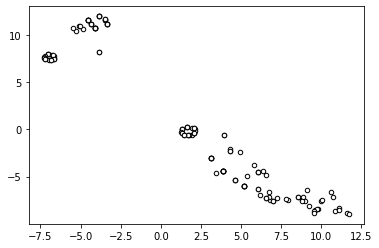

In [221]:
tsne = TSNE(n_components=2, random_state=0)
projections = tsne.fit_transform(dc[['Degree Centrality',-1,1,'anomaly_ratio','avg_monthly_act','"Bot"','"User"']])
X = projections[:,0]
y = projections[:,1]
plt.scatter(X, y , c="white", s=20, edgecolor="k")